In [46]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as GridSpec
from scipy.stats import probplot, f_oneway, pearsonr
#import joypy
from matplotlib import cm
import requests
import json
from bs4 import BeautifulSoup
import datetime
from geopy.distance import geodesic
from tqdm import tqdm
import numpy as np
import glob
import phik
from phik.report import plot_correlation_matrix
from sklearn.preprocessing import OrdinalEncoder
from tqdm import tqdm_pandas, tqdm



In [11]:
all_files = glob.glob(os.path.join("../data/raw/for_training", "*.csv"))
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

raw_df = pd.concat(li, axis=0, ignore_index=True)

In [12]:
print(raw_df.shape)


(117527, 11)


In [13]:
raw_df_columns_info = pd.DataFrame(index=raw_df.columns)
raw_df_columns_info["dtype"] = raw_df.dtypes.values
raw_df_columns_info["null values present"] = raw_df.isnull().any().values
raw_df_columns_info

,dtype,null values present
month,object,False
town,object,False
flat_type,object,False
block,object,False
street_name,object,False
storey_range,object,False
floor_area_sqm,float64,False
flat_model,object,False
lease_commence_date,int64,False
remaining_lease,object,False


In [14]:
raw_df_cat_var = raw_df.select_dtypes("object")
raw_df_con_var = raw_df.select_dtypes(["float","int"])

c:\Users\angus\Anaconda3\envs\hdb-env\lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable block is large: 2452. Are you sure this is not an interval variable? Analysis for pairs of variables including block can be slow.
  warnings.warn(


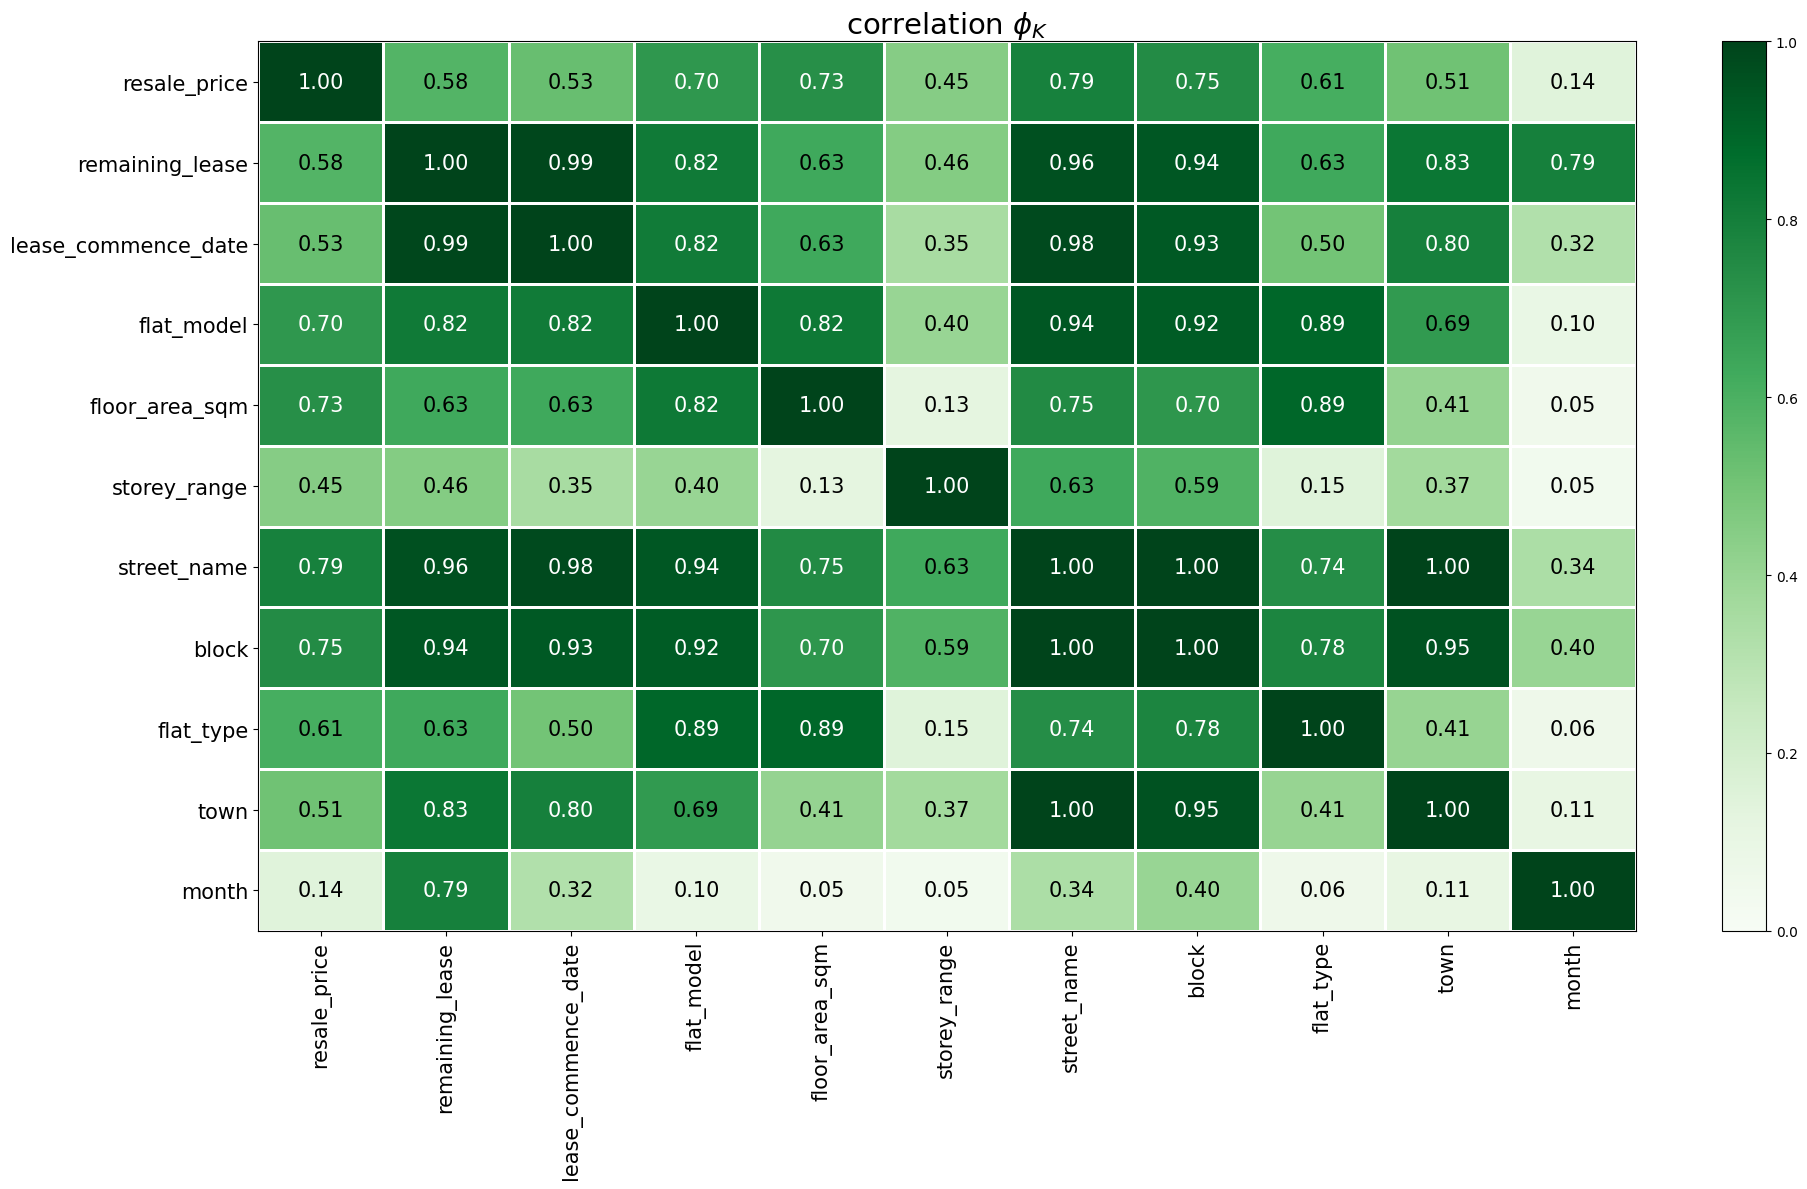

In [15]:
phik_overview = raw_df.phik_matrix(interval_cols=raw_df_con_var.columns)

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(20, 12))

From the correlation matrix, it seems that flat_model, flat_type and floor_area_sqm are correlated with resale price.

In [16]:
def target_variable_analysis(df, target_var):

    fig, axes = plt.subplots(1,3, figsize=(25,8))

    # QQ plot
    z = (df[target_var]-np.mean(df[target_var]))/np.std(df[target_var])
    probplot(z, dist="norm", plot=axes[0])
    axes[0].set_title("Normal Q-Q plot")

    # Histogram
    sns.histplot(ax = axes[1], data=df, x=target_var)
    axes[1].set_title(f"Distribution of {target_var}")

    # Boxplot
    sns.boxplot(ax = axes[2], data=df, y=target_var)
    axes[1].set_title(f"Boxplot of {target_var}")

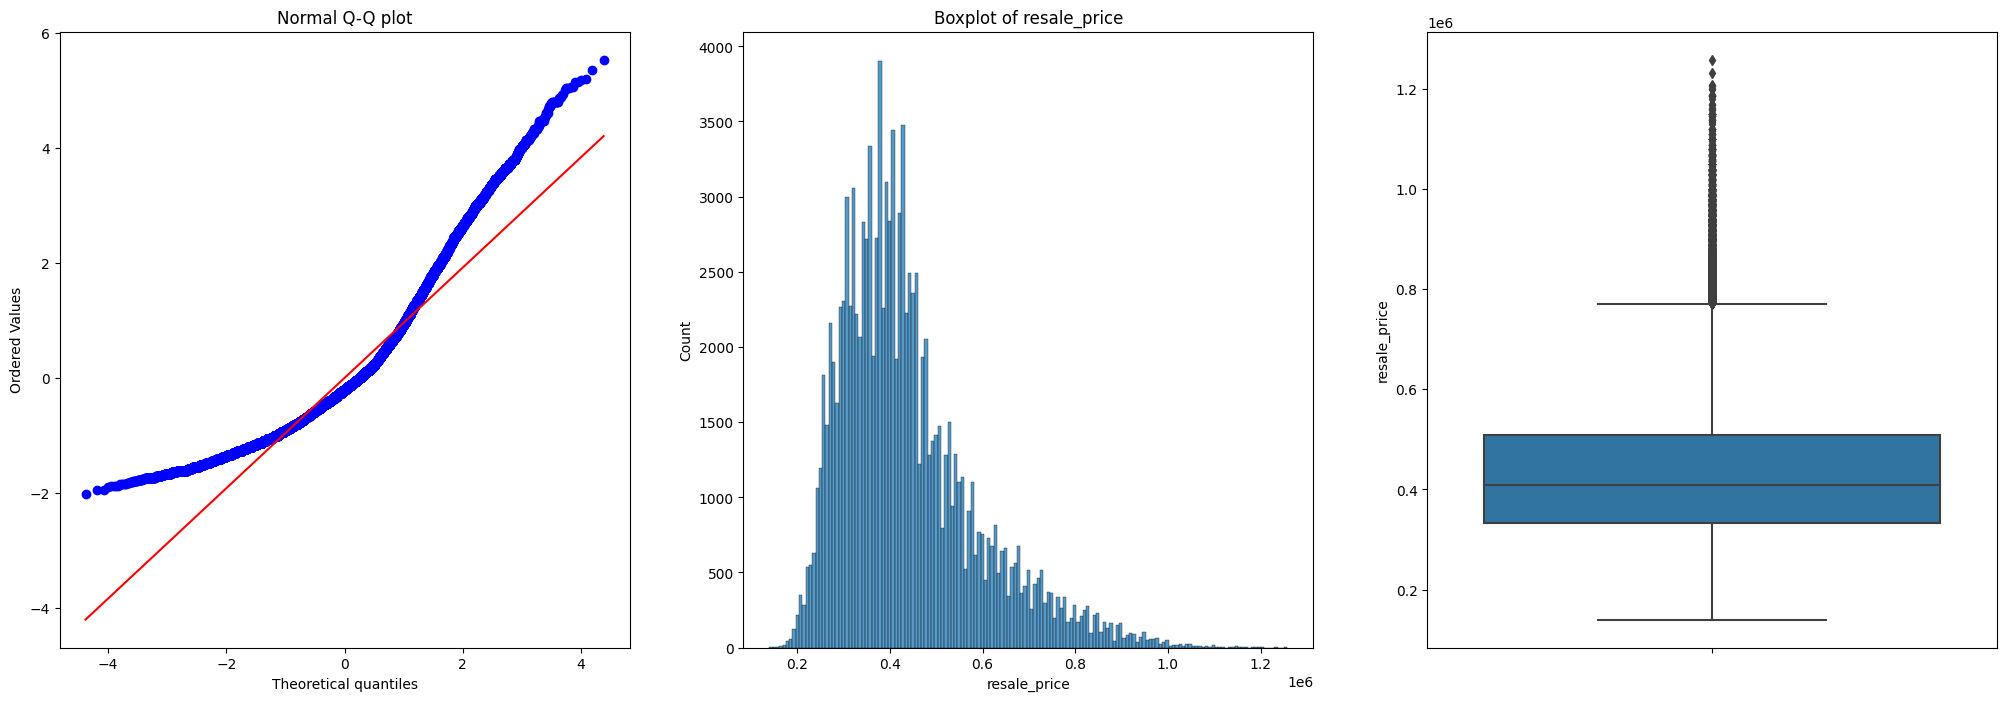

In [17]:
target_variable_analysis(raw_df, "resale_price")

Visually, there seem to be some outliers present in the resale_price target variable. We will need to investigate the cause of these outliers as they could belong to a specific category of flats

In [18]:
def categorical_variable_analysis(df, cat_var, target_var, xlabel_rot=0, xlabel_font=7):

    fig, axes = plt.subplots(3,1, figsize=(15,8))
    sns.boxplot(ax = axes[0], data=df, x=cat_var, y=target_var)
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=xlabel_rot, fontsize=xlabel_font)

    sns.histplot(ax = axes[1], data=df, x=target_var, hue=cat_var, multiple="stack", legend=False)
    sns.ecdfplot(ax = axes[2], data=df, x=target_var, hue=cat_var)
    
    # pearson_r_pvalue = pearsonr(df[con_var], df[target_var].astype(np.uint8)).pvalue

    # ttest_pvalue = ttest_ind(df[df[target_var] == 0][con_var],
    #                           df[df[target_var] == 1][con_var]).pvalue

    target_groups = df.groupby(cat_var)[target_var].apply(list)
    f_oneway_result = f_oneway(*target_groups)
    f_oneway_statistic = f_oneway_result.statistic
    f_oneway_pvalue = f_oneway_result.pvalue

    print(df.groupby(by=[cat_var]).agg(["count","mean","median"])[target_var].sort_values(by=["mean"], ascending=False).head(10))
    print("")
    print(f"{cat_var} One-Way ANOVA")
    print(f"F Statistic: {f_oneway_statistic}")
    print(f"p-value: {f_oneway_pvalue}")
    

def continous_variables_analysis(df, con_var, target_var):

    fig, axes = plt.subplots(1,3, figsize=(25,8))
    # QQ plot
    z = (df[con_var]-np.mean(df[con_var]))/np.std(df[con_var])
    probplot(z, dist="norm", plot=axes[0])
    axes[0].set_title(f"{con_var} Normal Q-Q plot")

    # Histogram
    sns.histplot(ax = axes[1], data=df, x=con_var)
    axes[1].set_title(f"Distribution of {con_var}")

    sns.regplot(ax = axes[2], x=con_var, y=target_var, data=df, scatter_kws={"s": 1, 'alpha':0.5}, line_kws={"color": "orange"})
    axes[2].set_title(f"Scatterplot of {con_var}")

    # sns.scatterplot(ax = axes[2], x=con_var, y=target_var, data=df, s=10)

    pearson_r_result = pearsonr(df[con_var], df[target_var])
    pearson_r_statistic = pearson_r_result.statistic
    pearson_r_pvalue = pearson_r_result.pvalue

    print(df[[con_var]].describe())
    print("")
    print(f"{con_var} Pearson R correlation")
    print(f"Pearson R Statistic: {pearson_r_statistic}")
    print(f"p-value: {pearson_r_pvalue}")

## Town

The top three towns with the highest mean resale price is Bukit Timah, Central Area, and Bishan (Approximately $711K, $639K and $629K respectively)

Using a one-way ANOVA test, the p-value is small enough (< 0.05) to reject the null hypothesis that the towns have the same mean resale price. We can accept the alternative hypothesis that the towns have differing mean resale prices with 95% confidence.

However, the "town" variable has high cardinality (26 unique values). Grouping them into different regions (eg. North, West, East etc) can reduce the number of unique values for this feature.

C:\Users\angus\AppData\Local\Temp\ipykernel_66424\343041520.py:20: FutureWarning: ['month', 'flat_type', 'block', 'street_name', 'storey_range', 'flat_model', 'remaining_lease'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  print(df.groupby(by=[cat_var]).agg(["count","mean","median"])[target_var].sort_values(by=["mean"], ascending=False).head(10))


                 count           mean    median
town                                           
BUKIT TIMAH        308  710937.720779  712500.0
CENTRAL AREA      1068  638812.460674  546500.0
BISHAN            2220  629354.431477  608000.0
BUKIT MERAH       4462  555898.326284  570000.0
QUEENSTOWN        3111  551900.054889  540000.0
MARINE PARADE      690  521462.266667  470000.0
KALLANG/WHAMPOA   3420  493662.319228  460000.0
PASIR RIS         3606  487433.499168  468000.0
SERANGOON         2427  484696.433869  460000.0
TOA PAYOH         3741  471493.952152  385000.0

town One-Way ANOVA
F Statistic: 918.7102577886361
p-value: 0.0


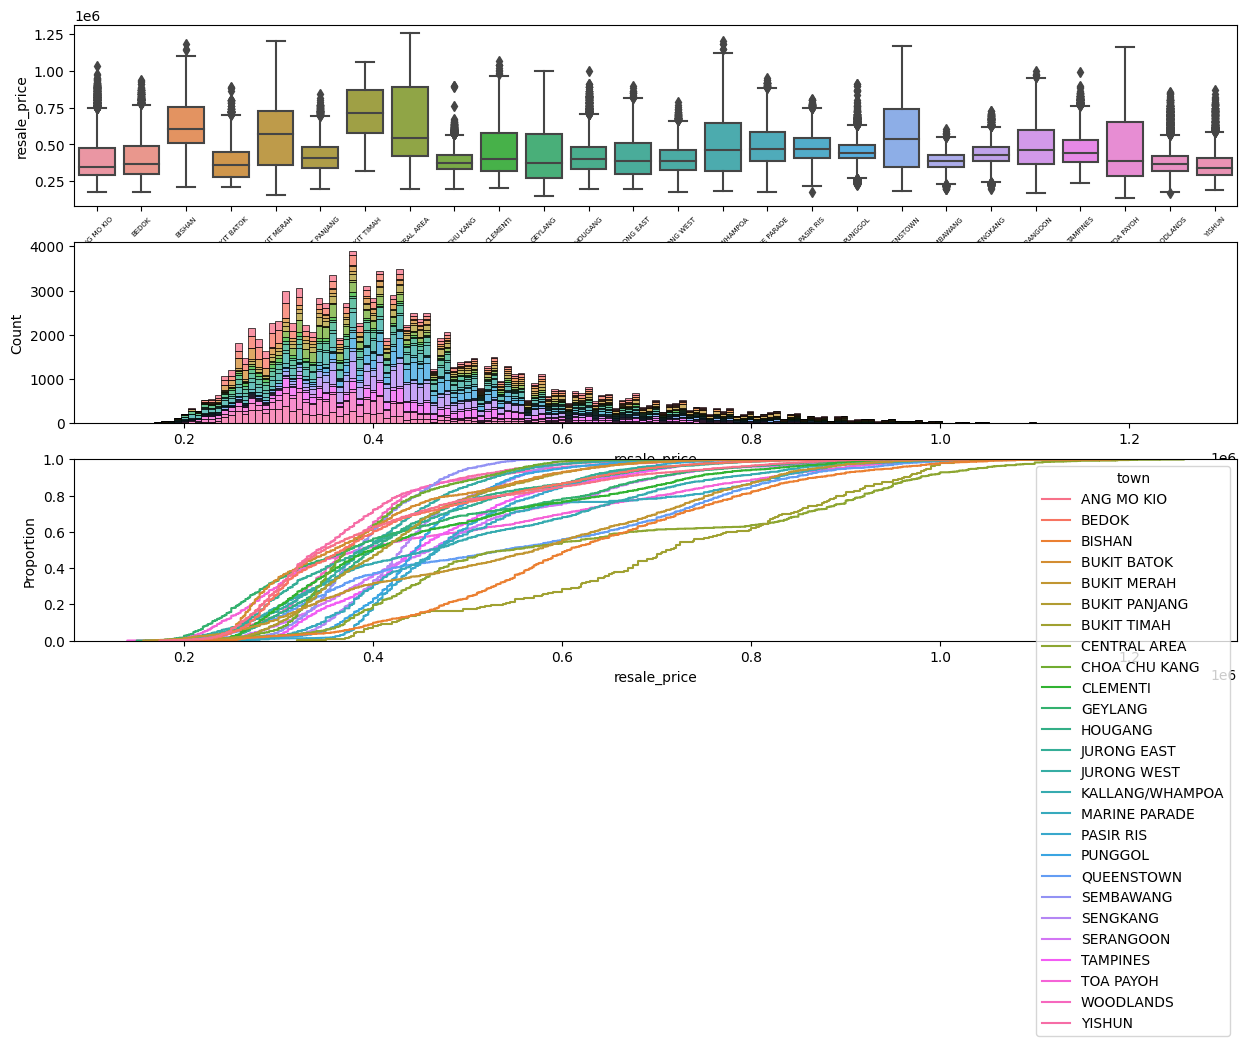

In [19]:
categorical_variable_analysis(raw_df, "town", "resale_price", xlabel_rot=45, xlabel_font=5)

C:\Users\angus\AppData\Local\Temp\ipykernel_66424\343041520.py:20: FutureWarning: ['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range', 'flat_model', 'remaining_lease'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  print(df.groupby(by=[cat_var]).agg(["count","mean","median"])[target_var].sort_values(by=["mean"], ascending=False).head(10))


           count           mean    median
region                                   
Central    21672  523709.219005  498000.0
East       18305  449483.898552  428888.0
Northeast  29344  438290.121521  425000.0
West       24221  413640.353140  390000.0
North      23985  378686.255051  365000.0

region One-Way ANOVA
F Statistic: 3302.554530349706
p-value: 0.0


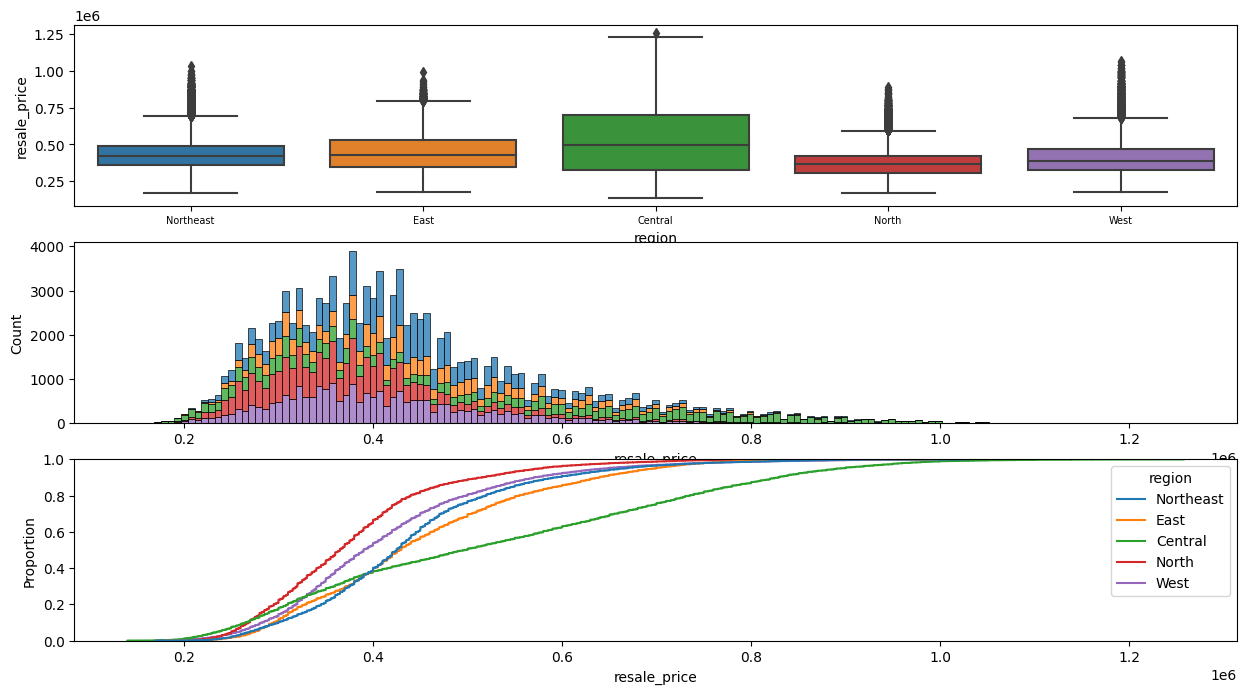

In [20]:
regions={"North":["WOODLANDS","SEMBAWANG","YISHUN","BUKIT BATOK"],
         "Northeast":["HOUGANG","SENGKANG","PUNGGOL","ANG MO KIO","SERANGOON"],
         "Central":["BUKIT MERAH","CENTRAL AREA","BISHAN","GEYLANG","KALLANG/WHAMPOA","QUEENSTOWN","TOA PAYOH","MARINE PARADE"],
         "West":["JURONG WEST","JURONG EAST","CLEMENTI","BUKIT PANJANG","BUKIT TIMAH","CHOA CHU KANG","LIM CHU KANG"],
         "East":["PASIR RIS","TAMPINES","BEDOK"]}


raw_df["region"] = raw_df["town"].map(
    {town: region for region, towns in regions.items() for town in towns}
)

categorical_variable_analysis(raw_df, "region", "resale_price")

After grouping the towns into regions, we are left with five unique regions. The region with the highest mean resale price is the Central region, which is about $524K. The next highest region is the East region, with a mean resale price of about $449K.

Same with the "town" variable, using the one-way ANOVA, we are able to reject the null hypothesis and accept the alternative hypothesis that that the regions have differing mean resale prices with 95% confidence.


## Flat Type

C:\Users\angus\AppData\Local\Temp\ipykernel_66424\343041520.py:20: FutureWarning: ['month', 'town', 'block', 'street_name', 'storey_range', 'flat_model', 'remaining_lease', 'region'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  print(df.groupby(by=[cat_var]).agg(["count","mean","median"])[target_var].sort_values(by=["mean"], ascending=False).head(10))


                  count           mean    median
flat_type                                       
MULTI-GENERATION     42  792989.333333  784444.0
EXECUTIVE          9251  624299.551779  600000.0
5 ROOM            28682  526297.815840  480000.0
4 ROOM            48472  434027.180432  405000.0
3 ROOM            29441  312962.844660  300000.0
2 ROOM             1588  235873.789043  233000.0
1 ROOM               51  190985.647059  188000.0

flat_type One-Way ANOVA
F Statistic: 14113.72820650605
p-value: 0.0


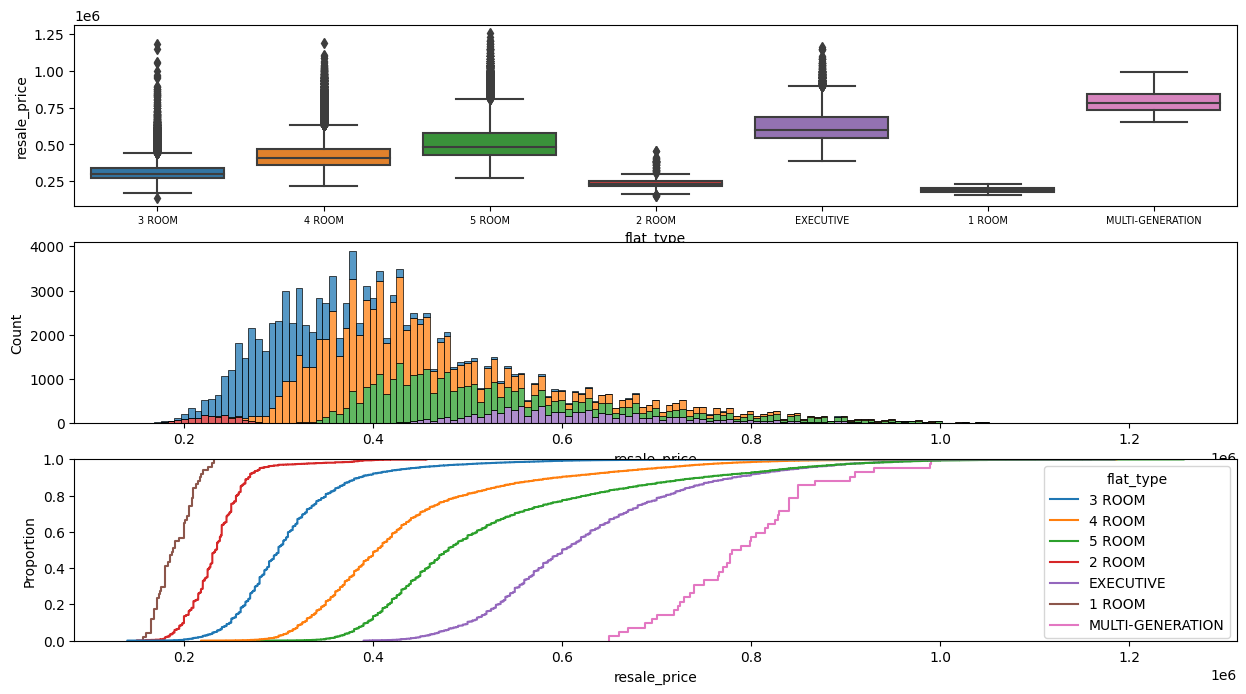

In [21]:
categorical_variable_analysis(raw_df, "flat_type", "resale_price")

There are very little samples with "MULTI-GENERATION" and "1 ROOM" flat types in the dataset. We can consider removing them from the dataset altogether, and focus on training a model on 2 to 5 room and executive flat types.

Majority of the flats are 4 room flats, with a mean resale price of about $434K

The result of the one-way ANOVA test indicates that that the flat types have differing mean resale prices with 95% confidence.

## Flat Model

C:\Users\angus\AppData\Local\Temp\ipykernel_66424\343041520.py:20: FutureWarning: ['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range', 'remaining_lease', 'region'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  print(df.groupby(by=[cat_var]).agg(["count","mean","median"])[target_var].sort_values(by=["mean"], ascending=False).head(10))


                        count          mean    median
flat_model                                           
Type S2                   129  1.014193e+06  998000.0
Type S1                   271  8.977962e+05  898000.0
Premium Apartment Loft     31  8.615956e+05  870000.0
Terrace                    70  8.198336e+05  810000.0
Multi Generation           42  7.929893e+05  784444.0
DBSS                     1537  7.580872e+05  760000.0
Premium Maisonette         12  7.448333e+05  715000.0
Model A-Maisonette        206  7.092751e+05  707500.0
Improved-Maisonette        18  6.818827e+05  677500.0
Adjoined flat             202  6.808183e+05  665000.0

flat_model One-Way ANOVA
F Statistic: 3219.078262442776
p-value: 0.0


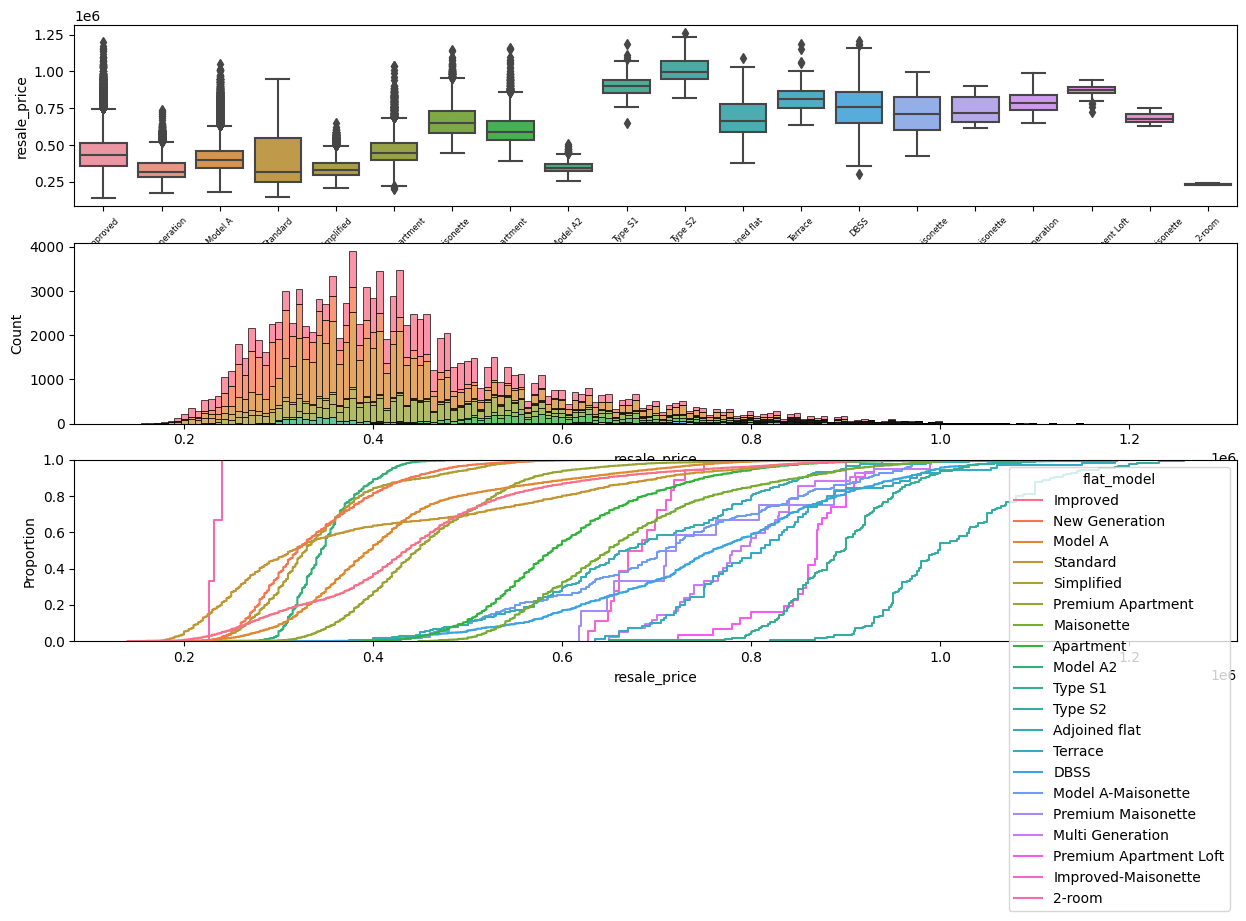

In [22]:
categorical_variable_analysis(raw_df, "flat_model", "resale_price", xlabel_rot=45, xlabel_font=6)

Same as the "town" variable, the "flat_model" variable has high cardinality (20 unique values). Consolidating them into broader categories of flat models can reduce the number of unique values for this feature.

C:\Users\angus\AppData\Local\Temp\ipykernel_66424\343041520.py:20: FutureWarning: ['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range', 'flat_model', 'remaining_lease', 'region'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  print(df.groupby(by=[cat_var]).agg(["count","mean","median"])[target_var].sort_values(by=["mean"], ascending=False).head(10))


                     count           mean    median
flat_model_replaced                                
MULTI GENERATION        42  792989.333333  784444.0
SPECIAL               2209  785073.453092  800000.0
MAISONETTE            3648  672791.195348  650000.0
APARTMENT            16925  501974.913969  485000.0
STANDARD             33022  444913.909557  430000.0
MODEL A              44292  411989.949275  383888.0
NEW GENERATION       17389  338304.712167  320000.0

flat_model_replaced One-Way ANOVA
F Statistic: 7984.270189972273
p-value: 0.0


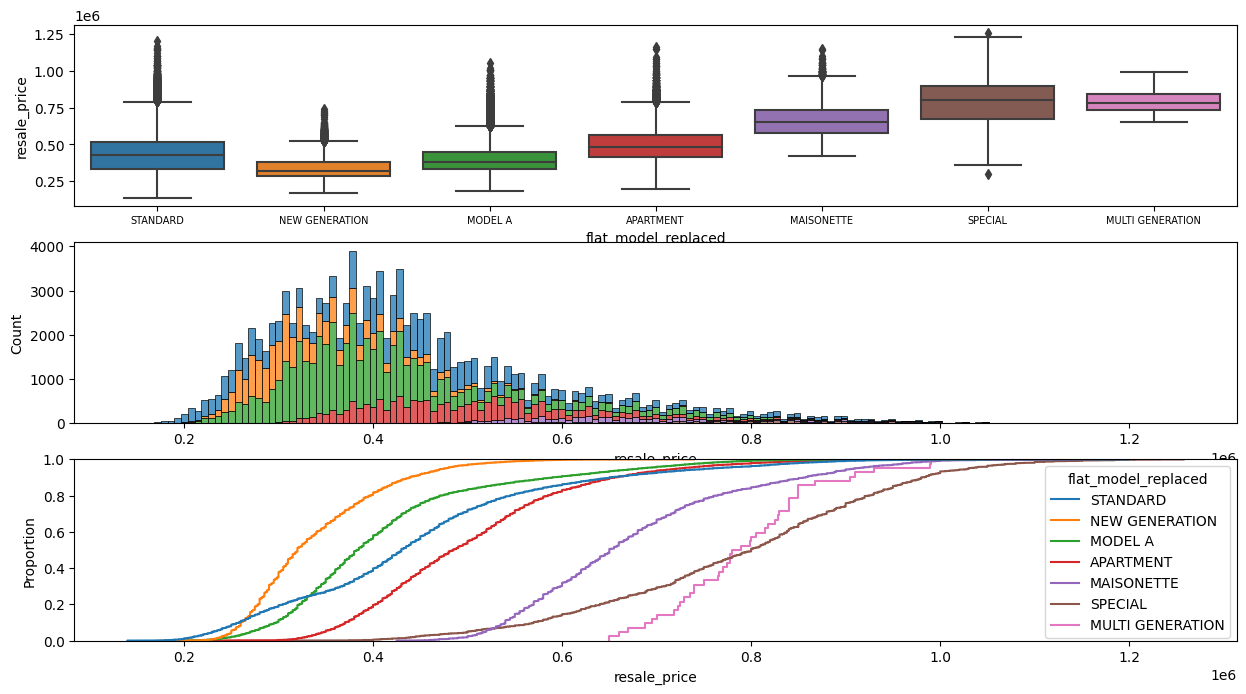

In [23]:
flat_model_replace = {"PREMIUM MAISONETTE":"MAISONETTE","IMPROVED-MAISONETTE":"MAISONETTE","MODEL A-MAISONETTE":"MAISONETTE",
                      "PREMIUM APARTMENT LOFT":"APARTMENT","TERRACE":"SPECIAL","ADJOINED FLAT":"SPECIAL", "TYPE S1":"SPECIAL",
                      "TYPE S2":"SPECIAL","DBSS":"SPECIAL","MODEL A2":"MODEL A","PREMIUM APARTMENT":"APARTMENT","IMPROVED":"STANDARD",
                      "SIMPLIFIED":"MODEL A","2-ROOM":"STANDARD"}
raw_df["flat_model"] = raw_df["flat_model"].str.upper()
raw_df["flat_model_replaced"] = raw_df["flat_model"].replace(flat_model_replace)
categorical_variable_analysis(raw_df, "flat_model_replaced", "resale_price")

Multi Generation flat models have the highest mean resale price of about $792K. However, there are only 42 samples. Majority of flats are Model A, and the mean resale price is about $412K.

Using the one-way ANOVA test, we are able to reject the null hypothesis and accept the alternative hypothesis that that the flat models have differing mean resale prices with 95% confidence.


## Storey range

C:\Users\angus\AppData\Local\Temp\ipykernel_66424\343041520.py:20: FutureWarning: ['month', 'town', 'flat_type', 'block', 'street_name', 'flat_model', 'remaining_lease', 'region', 'flat_model_replaced'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  print(df.groupby(by=[cat_var]).agg(["count","mean","median"])[target_var].sort_values(by=["mean"], ascending=False).head(10))


              count          mean     median
storey_range                                
43 TO 45         16  1.017562e+06  1010000.0
49 TO 51          9  1.007863e+06   988888.0
46 TO 48         21  9.871571e+05   988000.0
40 TO 42        109  8.840137e+05   890000.0
37 TO 39        206  8.339253e+05   842000.0
31 TO 33        211  8.090140e+05   815000.0
34 TO 36        215  8.048756e+05   835000.0
28 TO 30        500  7.465388e+05   771500.0
25 TO 27        793  6.648715e+05   680000.0
22 TO 24       1468  6.184617e+05   610000.0

storey_range One-Way ANOVA
F Statistic: 1381.995910237692
p-value: 0.0


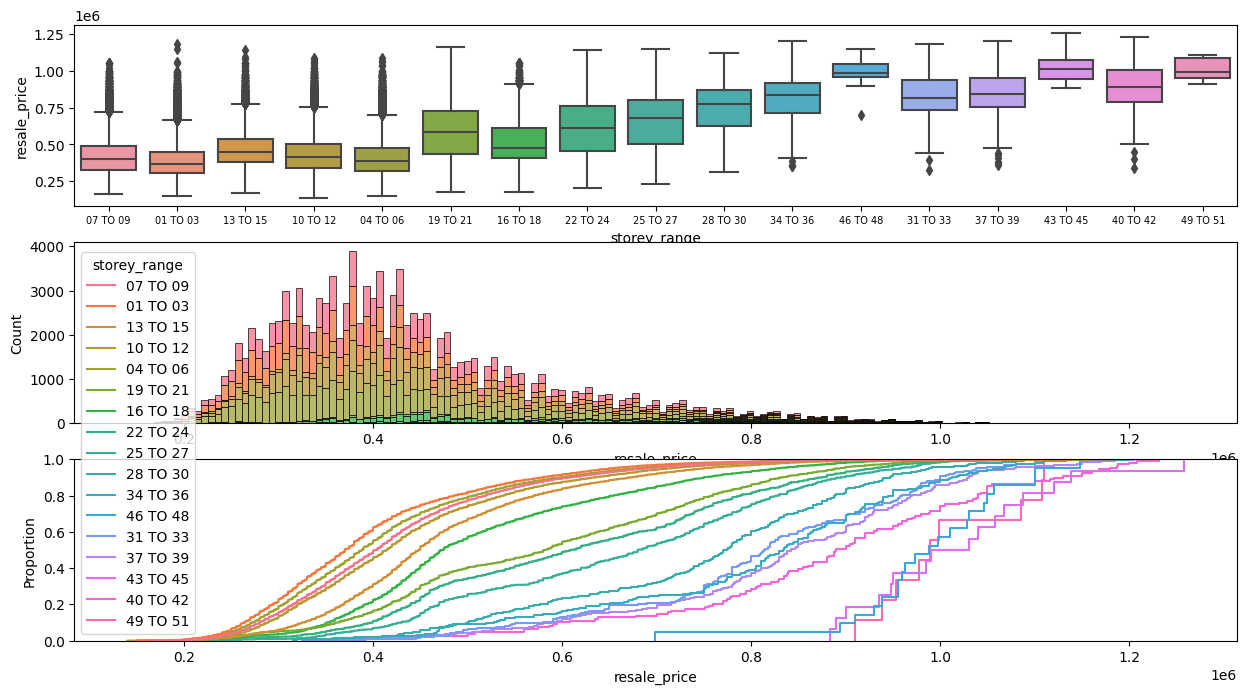

In [24]:
categorical_variable_analysis(raw_df, "storey_range", "resale_price")


It seems that the higher the storey range, the greater the mean resale price. It would make sense to perform ordinal encoding on the "storey_range" variable, converting from a categorical variable to a numerical variable.

       storey_range_encoded
count         117527.000000
mean               2.154356
std                1.873437
min                0.000000
25%                1.000000
50%                2.000000
75%                3.000000
max               16.000000

storey_range_encoded Pearson R correlation
Pearson R Statistic: 0.36907402072839324
p-value: 0.0


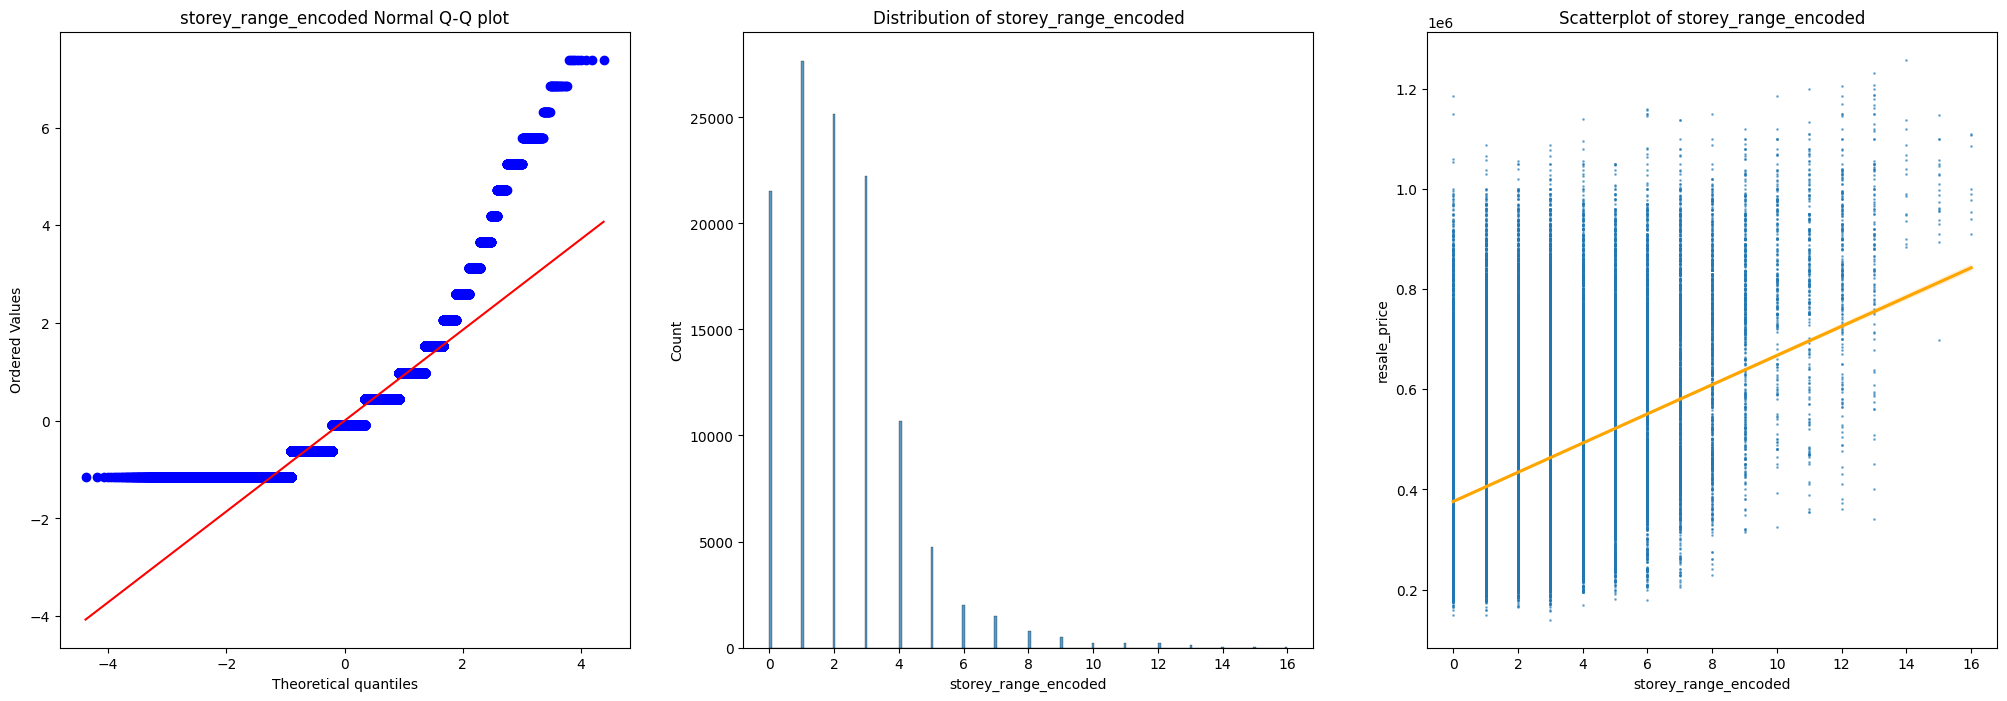

In [25]:
encoder = OrdinalEncoder()
table_to_encode = raw_df[["storey_range"]]
ord_table = pd.DataFrame(
    encoder.fit_transform(table_to_encode),
    columns=["storey_range_encoded"],
    index=table_to_encode.index,
)

raw_df = raw_df.join(ord_table)

continous_variables_analysis(raw_df, "storey_range_encoded", "resale_price")

After performing ordinal encoding on the "storey_range" feature, we can see that a slight postive correlation exists (0.369) between the storey range and the resale price of a flat, based on the scatter plot and the sign of the pearson R statistic value. 

The p value of the pearson R statistic also indicates that we can reject the null hypothesis with 95% confidence that the distributions underlying the samples are uncorrelated 

The mean value of the encoded storey range is approximately 2, which indicates that the average storey range of all flats transacted is from 7 to 9


## Floor area

       floor_area_sqm
count   117527.000000
mean        97.428947
std         24.259687
min         31.000000
25%         77.000000
50%         95.000000
75%        112.000000
max        280.000000

floor_area_sqm Pearson R correlation
Pearson R Statistic: 0.6386880083765487
p-value: 0.0


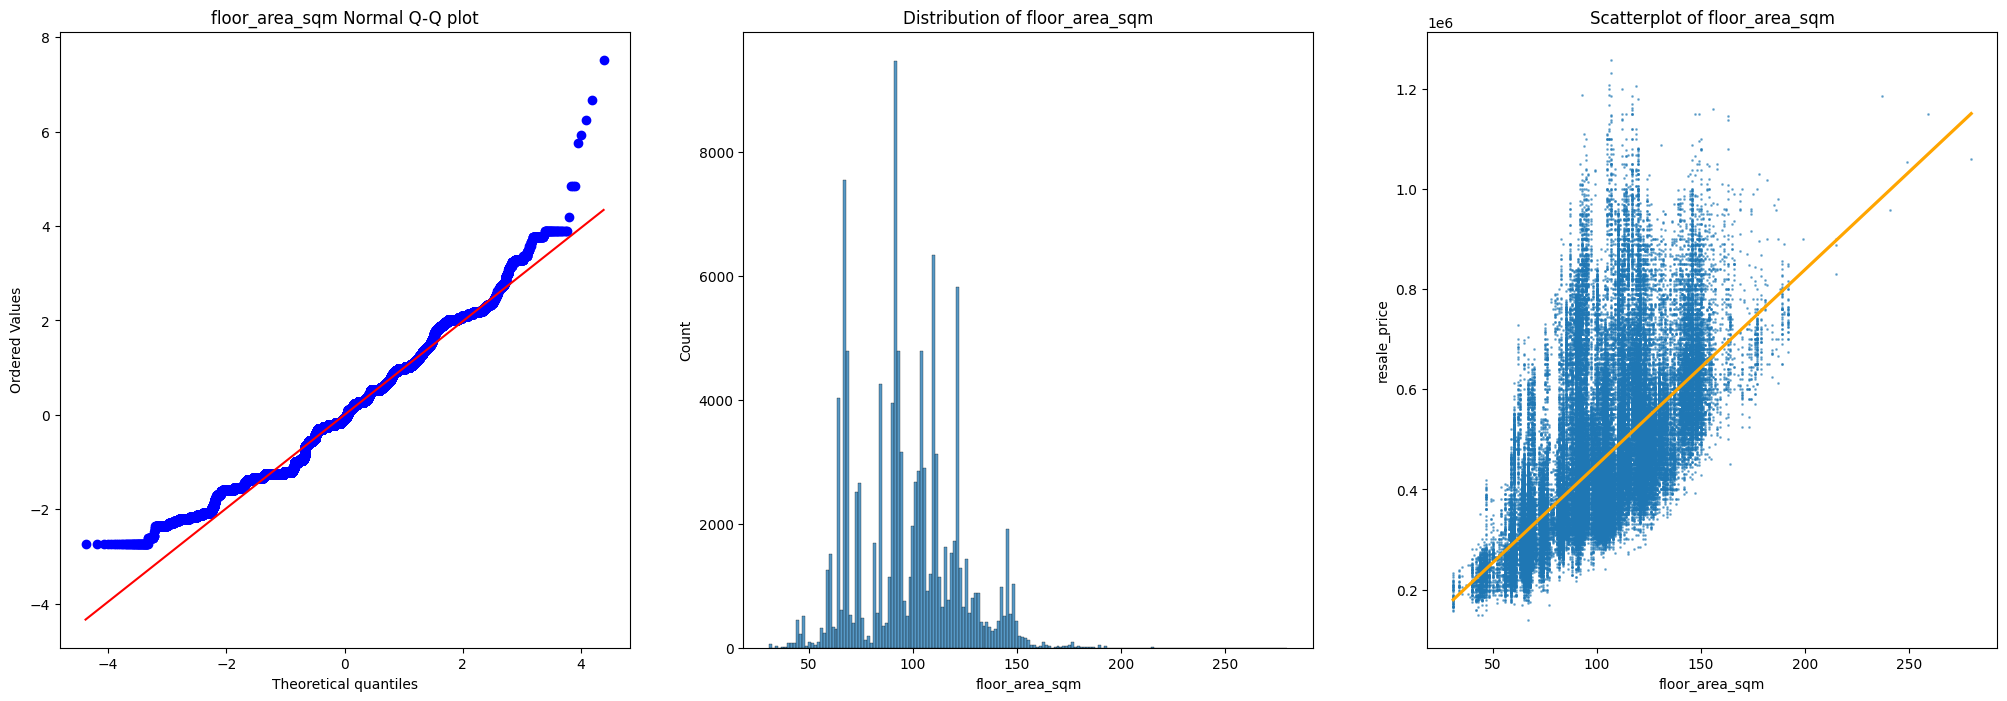

In [26]:
continous_variables_analysis(raw_df, "floor_area_sqm", "resale_price")

As expected, there is a strong postive correlation exists (0.639) between the floor area and the resale price of a flat, based on the scatter plot and the sign of the pearson R statistic value. 

The mean floor area among all flats is 97.4 square meters

## Lease Commence Date/Lease Age

Using the lease commence date and the month-year of the flat transaction, we can calculate the lease age of each flat and analyze it as a new feature.

           lease_age
count  117527.000000
mean       24.398266
std        12.206074
min         1.000000
25%        15.000000
50%        25.000000
75%        34.000000
max        54.000000

lease_age Pearson R correlation
Pearson R Statistic: -0.33883990901755223
p-value: 0.0


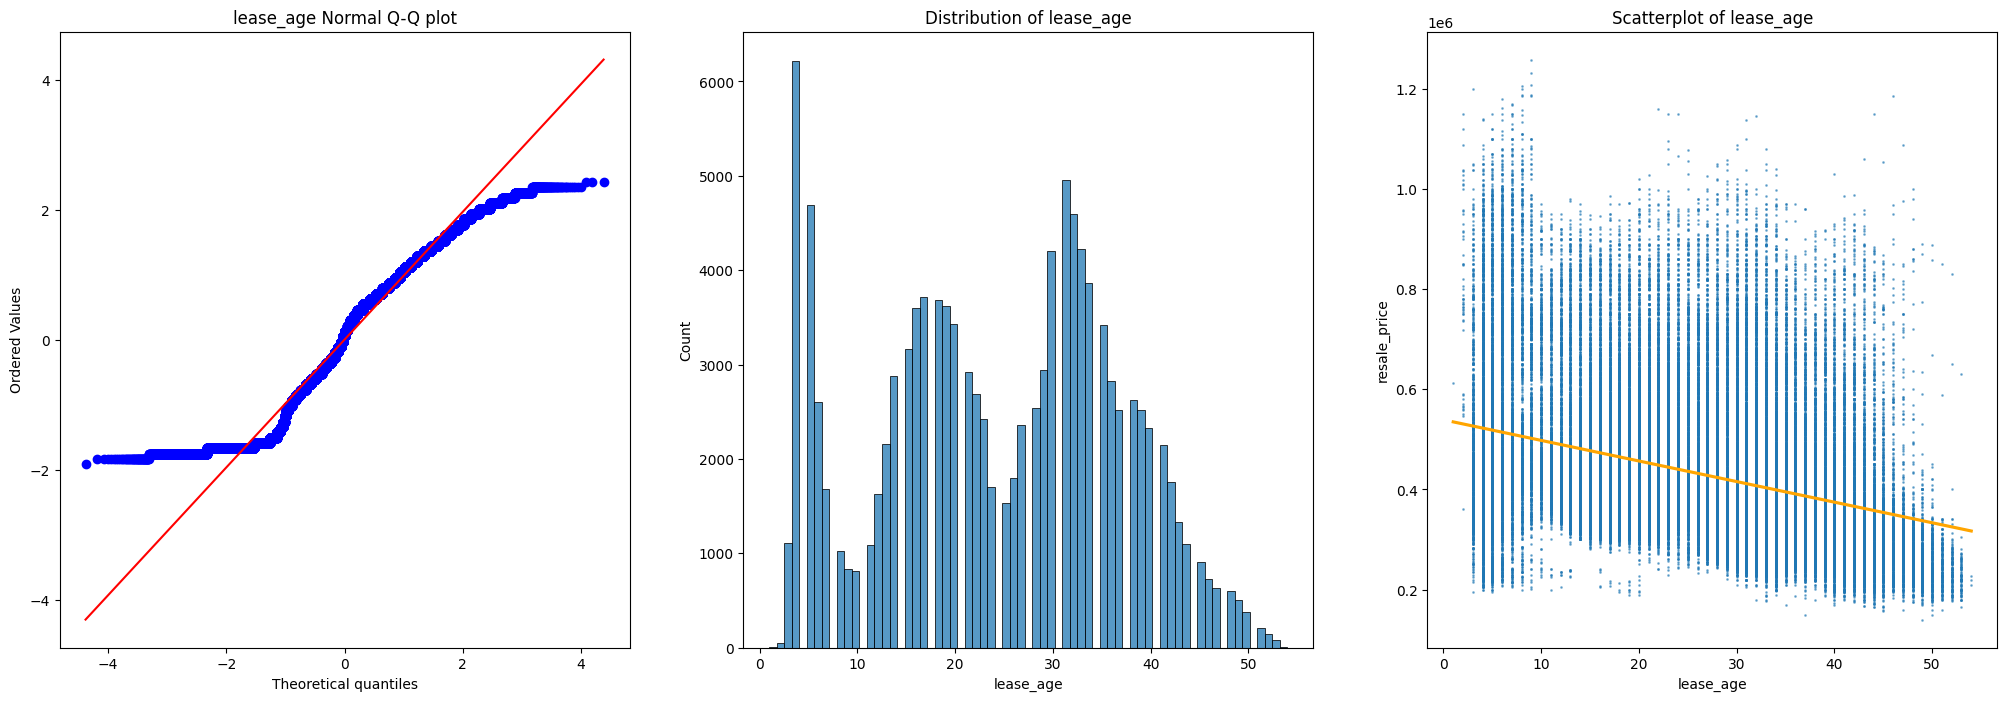

In [27]:
raw_df["month"] = pd.to_datetime(raw_df["month"])
raw_df["year_month"] = raw_df["month"]
raw_df["month"] = raw_df["year_month"].dt.month
raw_df["year"] = raw_df["year_month"].dt.year


raw_df["lease_age"] = (
    raw_df["year"] - raw_df["lease_commence_date"]
)

continous_variables_analysis(raw_df, "lease_age", "resale_price")

There is slight negative correlation (-0.339) between the lease age and the resale price of a flat, based on the scatter plot and the sign of the pearson R statistic value. The older a flat, the lower its resale price is, which is not surprising. 

The mean lease age among all flats about 24 years

<Axes: xlabel='resale_price', ylabel='lease_age'>

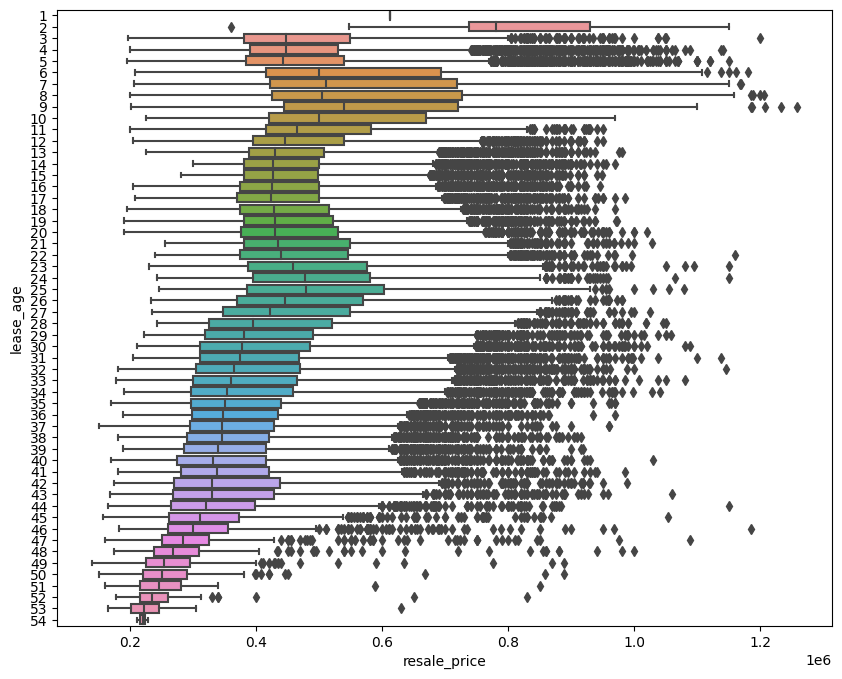

In [28]:
fig = plt.figure(figsize=(10,8))
sns.boxplot(y="lease_age",x="resale_price", data=raw_df, orient="h")

## Remaining Lease, Month and Year

- Remaining Lease: This feature was not analyzed as it is likely correlated with lease age and lease commence date. Lease age alone should suffic  as a feature for factoring in the flat's duration of existence when estimating the resale value. Moreover, the data quality is inconsistent (eg 86 years, 86, 86 years 07 months). Hence the effort required to clean this feature was not worth the insights that can be obtained from doing so.

- Year: As of now there are six years worth of transactions (2015 to 2020 inclusive). Although there are only six unique values for this feature, as flat resale values are likely to be strongly affected by economic conditions during each year, this feature should be kept for training the model to estimate the resale value.


Overview of raw features EDA




Generating new features using flat coordinates

## Getting flat coordinates

In [29]:
def find_coordinates(add: str) -> tuple:
    """With the block number and street name, get the full address of the hdb flat,
    including the postal code, geogaphical coordinates (lat/long)

    Args:
        add (str): block number and street name

    Returns:
        tuple: latitude and longitude coordinates
    """
    # Do not need to change the URL
    url = (
        "https://developers.onemap.sg/commonapi/search?returnGeom=Y&getAddrDetails=Y&pageNum=1&searchVal="
        + add
    )

    # Retrieve information from website
    response = requests.get(url)
    try:
        data = json.loads(response.text)
    except ValueError:
        print("JSONDecodeError")
        pass

    if len(data["results"]) != 0:
        result = data["results"][0]
        latitude, longitude = float(result["LATITUDE"]), float(result["LONGITUDE"])

    else:
        latitude, longitude = float("inf"), float("inf")

    return latitude, longitude



In [82]:
# tqdm_pandas(tqdm())
# flat_coordinates = pd.DataFrame(
#             raw_df.progress_apply(
#                 lambda x: find_coordinates(
#                     x["block"] + " " + x["street_name"]
#                 ),
#                 axis=1,
#             ).tolist(),
#             columns=["latitude", "longitude"],
#         )
# flat_coordinates["block"] = raw_df["block"]
# flat_coordinates["street_name"] = raw_df["street_name"]
# flat_coordinates.to_csv("../data/eda/flat_coordinates.csv")

0it [00:00, ?it/s]
117527it [3:22:54,  9.65it/s]


In [30]:
flat_coordinates = pd.read_csv("../data/eda/flat_coordinates.csv")
raw_df = pd.merge(raw_df, flat_coordinates.drop_duplicates(), how="left", on=["block","street_name"])


### Schools

In [48]:
school_coordinates = pd.read_csv('../data/for_feature_engineering/schools/school_coordinates.csv')
school_coordinates = school_coordinates[["address","LATITUDE","LONGITUDE"]]


In [38]:
def find_nearest_amenities(
    flat_transaction: pd.Series,
    amenity_details: pd.DataFrame,
    radius: int,
    period: bool,
) -> tuple:
    """Function to find the number of amenities within radius
    of a flat, and also the flat's distance to the nearest amenity

    Args:
        flat_transaction (pd.Series): flat transaction details (eg year_month, coordinates)
        amenity_details (pd.DataFrame): amenity details (eg year_month, coordinates)
        radius (int): radius around the flat
        period (bool): whether to take into account the opening date of the amenity

    Returns:
        tuple: nearest amenities information for the flat
    """

    flat_coordinates = (
        flat_transaction["latitude"],
        flat_transaction["longitude"],
    )
    transaction_year_month = flat_transaction["year_month"]
    no_of_amenities_within_radius = 0
    distance_to_nearest_amenity = float("inf")
    if flat_coordinates != (float("inf"), float("inf")):
        if period:
            amenity_details["distance_to_flat"] = amenity_details.apply(lambda row: float(
                        str(geodesic(flat_coordinates, (row["LATITUDE"], row["LONGITUDE"])))[:-3]
                    ) if transaction_year_month >= row["year_month"], axis = 1)
        else:
            amenity_details["distance_to_flat"] = amenity_details.apply(lambda row: float(
                            str(geodesic(flat_coordinates, (row["LATITUDE"], row["LONGITUDE"])))[:-3]
                        ), axis = 1)

        distance_to_nearest_amenity = min(amenity_details["distance_to_flat"])
        no_of_amenities_within_radius = len(amenity_details[amenity_details["distance_to_flat"] <= radius])

    return no_of_amenities_within_radius, distance_to_nearest_amenity

In [ ]:
tqdm_pandas(tqdm())
school_features = pd.DataFrame(raw_df.progress_apply(lambda flat: find_nearest_amenities(flat,
                                                                                amenity_details=school_coordinates,
                                                                                radius=2,
                                                                                period=False),axis=1).tolist(),
                                                                                columns=["no_of_schools_within_2_km", "distance_to_nearest_school"])

In [ ]:
raw_df = pd.concat([raw_df, school_features], axis=1)

In [ ]:
continous_variables_analysis(raw_df, "no_of_schools_within_2_km", "resale_price")

In [ ]:
continous_variables_analysis(raw_df, "distance_to_nearest_school", "resale_price")

### MRT Stations

In [ ]:
mrt_station_coordinates_w_period = pd.read_csv('../data/for_feature_engineering/mrt_stations/mrt_station_coordinates_w_period.csv')
mrt_station_coordinates_w_period = mrt_station_coordinates_w_period.rename(columns={"Opening year": "YEAR", "Opening month": "MONTH"})
mrt_station_coordinates_w_period["year_month"] = pd.to_datetime(mrt_station_coordinates_w_period[["YEAR", "MONTH"]].assign(DAY=1))
mrt_station_coordinates_w_period = mrt_station_coordinates_w_period[["Name", "LATITUDE", "LONGITUDE", "year_month"]]

In [ ]:
tqdm_pandas(tqdm())
mrt_stations_features = pd.DataFrame(raw_df.apply(lambda flat: find_nearest_amenities(flat,
                                                                                    amenity_details=mrt_station_coordinates_w_period,
                                                                                    radius=2,
                                                                                    period=True),axis=1).tolist(),
                                                                                    columns=["no_of_mrt_stations_within_2_km", "distance_to_nearest_mrt_station"])

In [ ]:
raw_df = pd.concat([raw_df, mrt_stations_features], axis=1)

In [ ]:
continous_variables_analysis(raw_df, "no_of_mrt_stations_within_2_km", "resale_price")


In [ ]:
continous_variables_analysis(raw_df, "distance_to_nearest_mrt_station", "resale_price")


### Malls

In [ ]:
mall_coordinates = pd.read_csv('../data/for_feature_engineering/malls/mall_coordinates.csv')
mall_coordinates = mall_coordinates[["address","LATITUDE","LONGITUDE"]]

In [56]:
tqdm_pandas(tqdm())
malls_features = pd.DataFrame(raw_df.apply(lambda flat: find_nearest_amenities(flat,
                                                                                amenity_details=mall_coordinates,
                                                                                radius=2,
                                                                                period=False),axis=1).tolist(),
                                                                                columns=["no_of_malls_within_2_km", "distance_to_nearest_mall"])

In [ ]:
raw_df = pd.concat([raw_df, malls_features], axis=1)

In [ ]:
continous_variables_analysis(raw_df, "no_of_malls_within_2_km", "resale_price")

In [ ]:
continous_variables_analysis(raw_df, "distance_to_nearest_mall", "resale_price")

### Parks

In [64]:
park_coordinates = pd.read_csv('../data/for_feature_engineering/parks/park_coordinates.csv')
park_coordinates = park_coordinates[["address","LATITUDE","LONGITUDE"]]

In [ ]:
tqdm_pandas(tqdm())
parks_features = pd.DataFrame(raw_df.apply(lambda flat: find_nearest_amenities(flat,
                                                                                amenity_details=park_coordinates,
                                                                                radius=2,
                                                                                period=False),axis=1).tolist(),
                                                                                columns=["no_of_parks_within_2_km", "distance_to_nearest_park"])

In [ ]:
raw_df = pd.concat([raw_df, parks_features], axis=1)

In [ ]:
continous_variables_analysis(raw_df, "no_of_parks_within_2_km", "resale_price")

In [ ]:
continous_variables_analysis(raw_df, "distance_to_nearest_park", "resale_price")